In [1]:
import numpy as np
import pandas as pd
import pickle
import re
import importlib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import style
import plotly.graph_objects as go

import util
import plot

# 1. Duration and balance of apn label

In [2]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

duration = []
pos_num, neg_num = 0, 0
patient_num = {'A': 0, 'B': 0, 'C': 0}
apn_duration = {'A': [], 'B': [], 'C': []}
for file in file_full:
    with open('data/processed/' + file + '.pkl', 'rb') as f:
        res = pickle.load(f)
        apn = res['apn']
        
    # Determine patient group
    if file[0] == 'x':
        group = util.ecg_diagnose(apn)
    else:
        group = file[0].upper()

    # Continuous apnea duration
    apn = np.array2string(apn.astype(int)) # Convert label to string 00011...
    apn = ''.join(re.split(' |\n',apn)) # Remove space and line break
    apn_duration[group].append(list(map(len, re.findall(r'1+', apn)))) # Length of continuous 1

    # Number of apnea and non-apnea minutes
    pos_num += len(re.findall(r'1', apn))
    neg_num += len(re.findall(r'0', apn))

    # Number of each diagnosis group
    patient_num[group] += 1 

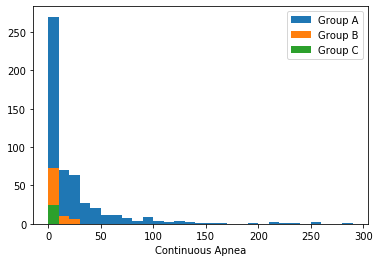

In [3]:
duration_A = np.hstack(apn_duration['A'])
duration_B = np.hstack(apn_duration['B'])
duration_C = np.hstack(apn_duration['C'])

plt.hist(duration_A, np.arange(0, 300, 10))
plt.hist(duration_B, np.arange(0, 300, 10))
plt.hist(duration_C, np.arange(0, 300, 10))
# plt.ylim((0, 50))
plt.legend(['Group A', 'Group B', 'Group C'])
plt.xlabel('Continuous Apnea')
plt.show()

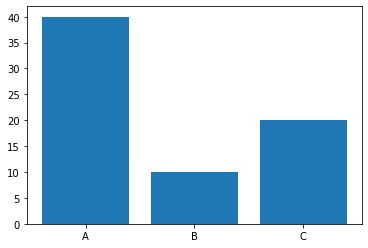

In [4]:
plt.bar(range(3), patient_num.values())
plt.xticks(range(3), labels=patient_num.keys())
plt.show()

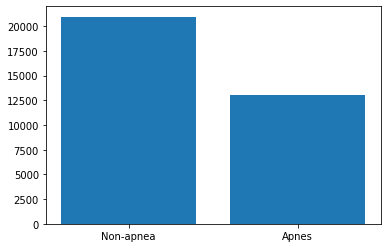

In [5]:
plt.bar([0, 1], [neg_num, pos_num])
plt.xticks([0, 1], labels=['Non-apnea', 'Apnes'])
plt.show()

## 1.1 Train-Test split

In [2]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

df = pd.DataFrame(columns=['file', 'group'])
for file in file_full:
    if file[0] == 'x':
        with open('data/raw/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']
            group = util.ecg_diagnose(apn)
    else:
        group = file[0].upper()
    
    df = df.append({
        'file': file,
        'group': group
    }, ignore_index=True)
        

In [9]:
df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df.group, random_state=123)

In [18]:
df_test.iloc[[1, 0, 4], :] # Select one sample from each group

,file,group
57,x23,A
37,x03,B
25,c01,C


In [19]:
df_test.to_csv('resources/File_test.csv', index=False)
df_train.to_csv('resources/File_train.csv', index=False)
df_test.iloc[[1, 0, 4], :].to_csv('resources/File_sample.csv', index=False)

In [20]:
df_test['group'].value_counts() / df['group'].value_counts()

A    0.2
C    0.2
B    0.2
Name: group, dtype: float64

# 2. Temporal features of heart rate
    Data to label mapping: Overlapping 3-min data to one label
    Data cleaning: Remove outliers (hr > 2), low pass filter
    Potential features: range, sd

In [2]:
from scipy import signal
b, a = signal.butter(3, 0.1)

In [13]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

In [14]:
with open('features/HR_' + 'a01' + '.pkl', 'rb') as f:
    res = pickle.load(f)
    hr = res['hr']
    t_hr = res['t'] # in minute
    
ac = autocorr(hr)

In [19]:
pd.Series(hr).autocorr(1)

0.7965690067312277

In [23]:
def features_time(file_names, seg_num=1):
    # seg_num: Window size for feature extraction, should be odd number
    df= pd.DataFrame()

    for file in file_names:
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute
            
        # Remove outliers (defined as hr > 2)
        idx_valid = (hr < 2) & (hr > 0.5)
        hr = hr[idx_valid]
        t_hr = t_hr[idx_valid]

        # Filter out noise
        hr_smth = signal.filtfilt(b, a, hr)
        
        group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper() 
        for minute in range(len(apn) - seg_num + 1):
            data = hr_smth[(t_hr > minute) & (t_hr < minute + seg_num)]
            if len(data) < 30: 
                continue
            md = np.median(data)
            df = df.append({
#                     'median': data.median(),
                'md': md,
                'min_r': data.min() - md,
                'max_r': data.max() - md,
                'p25_r': np.percentile(data, 0.25) - md,
                'p75_r': np.percentile(data, 0.75) - md,
                'mean_r': data.mean() - md,
                'std': data.std(),
                'acf1': pd.Series(data).autocorr(1),
                'acf2': pd.Series(data).autocorr(2),
                'apn': apn[minute + int(seg_num / 2)],
                'group': group,
                'file': file
            }, ignore_index=True)
                    
    df['apn'] = df['apn'].astype(int)
    return df

In [4]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

df = get_hr_range_sd(file_full)

(0, 0.6)

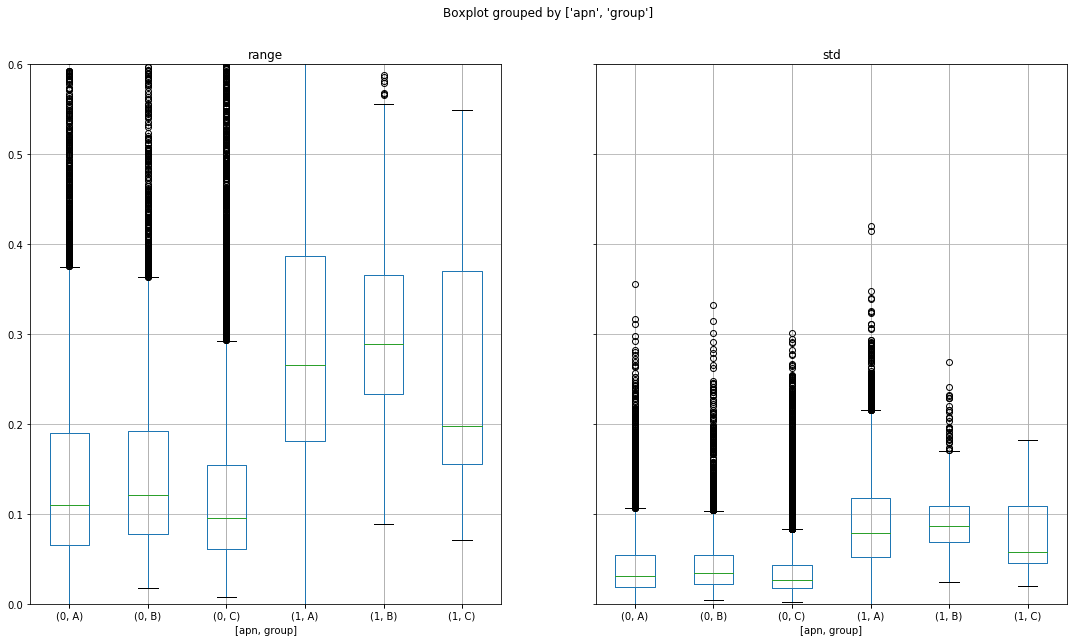

In [127]:
ax = df.boxplot(column=['range', 'std'], by=['apn', 'group'], figsize=(18,10))
ax[0].set_ylim(0, 0.6)
ax[1].set_ylim(0, 0.6)

## 2.1 Simple model

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

def model_evaluation_CV(mdl, df, train_df, n=5):
    skf = StratifiedKFold(n_splits=n)
    acc = []
    for idx_train, idx_val in skf.split(train_df, train_df['group']):
#         print(train_df.loc[idx_val, 'group'].value_counts() / train_df['group'].value_counts())
#         print(train_df.loc[idx_train, 'file'])
        file_train, file_val = train_df.loc[idx_train, 'file'], train_df.loc[idx_val, 'file']
#         print(len(np.unique(file_train)) + len(np.unique(file_val)) - len(train_df))
        X_train, X_val = df.loc[df.file.isin(file_train), feature_col], df.loc[df.file.isin(file_val), feature_col]
        y_train, y_val = df.loc[df.file.isin(file_train), label_col], df.loc[df.file.isin(file_val), label_col]

        mdl.fit(X_train, y_train)
        acc.append(metrics.accuracy_score(y_val, mdl.predict(X_val)))

    return np.mean(acc)

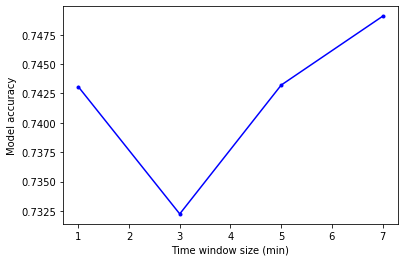

In [27]:
train_df = pd.read_csv('resources\File_train.csv')
feature_col, label_col = ['md', 'min_r', 'p25_r', 'mean_r', 'p75_r', 'max_r', 'std', 'acf1', 'acf2'], 'apn'
acc=[]
for seg_num in [1, 3, 5, 7]:
    df = features_time(train_df['file'], seg_num)
    mdl = LogisticRegression(solver='lbfgs')
    acc.append(model_evaluation_CV(mdl, df, train_df, n=5))

plt.plot([1, 3, 5, 7], acc, 'b.-')
plt.xlabel('Time window size (min)')
plt.ylabel('Model accuracy')
plt.show()

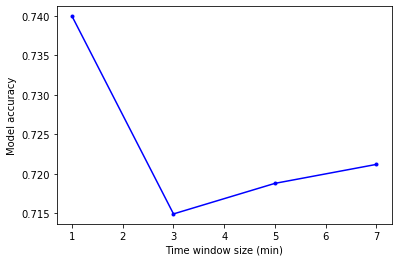

In [28]:
train_df = pd.read_csv('resources\File_train.csv')
feature_col, label_col = ['md', 'min_r', 'p25_r', 'mean_r', 'p75_r', 'max_r', 'std'], 'apn'
acc=[]
for seg_num in [1, 3, 5, 7]:
    df = features_time(train_df['file'], seg_num)
    mdl = LogisticRegression(solver='lbfgs')
    acc.append(model_evaluation_CV(mdl, df, train_df, n=5))

plt.plot([1, 3, 5, 7], acc, 'b.-')
plt.xlabel('Time window size (min)')
plt.ylabel('Model accuracy')
plt.show()

# 3. Frequency features of heart rate

In [79]:
def get_hr_psd(file_names, seg_num=3):
    # seg_num: Window size for feature extraction, should be odd number
    fs_new = 2.4
    res_apn, res_psd = [], []
    
    for file in file_names:
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute

        # Remove outliers (defined as hr > 2)
        idx_valid = hr < 2
        hr = hr[idx_valid]
        t_hr = t_hr[idx_valid]

        # Filter out noise
        hr_smth = signal.filtfilt(b, a, hr)

        # Resample data
        t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
        hr_interp = np.interp(t_interp, t_hr, hr_smth)

        # Extract range and sd for each 3-min window
        for minute in range(len(apn) - seg_num + 1):
            freqs, psd = signal.welch(
                x=hr_interp[(t_interp > minute) & (t_interp < minute + seg_num)], 
                fs=fs_new)
            res_psd.append(psd)
            res_apn.append(apn[minute + int(seg_num / 2)])
        
    res_psd = np.vstack(res_psd)
    res_apn = np.hstack(res_apn)
    return res_psd, res_apn, freqs


In [168]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

res_psd, res_apn, freqs = get_hr_psd(file_full)

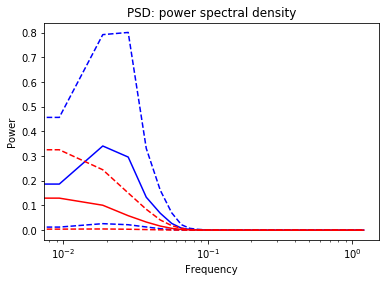

In [183]:
pos_mean = res_psd[res_apn==True].mean(axis=0)
neg_mean = res_psd[res_apn==False].mean(axis=0)
pos_90 = np.quantile(res_psd[res_apn==True], 0.9, axis=0)
pos_10 = np.quantile(res_psd[res_apn==True], 0.1, axis=0)
neg_90 = np.quantile(res_psd[res_apn==False], 0.9, axis=0)
neg_10 = np.quantile(res_psd[res_apn==False], 0.1, axis=0)

plt.semilogx(freqs, pos_mean, 'b-')
plt.semilogx(freqs, pos_90, 'b--')
plt.semilogx(freqs, pos_10, 'b--')
plt.semilogx(freqs, neg_mean, 'r-')
plt.semilogx(freqs, neg_90, 'r--')
plt.semilogx(freqs, neg_10, 'r--')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

In [128]:
def features_psd(file_names, seg_num=5, fs_new=2.4):
    # seg_num: Window size for feature extraction, should be odd number
    # fs_new: Resampling frequency
    df= pd.DataFrame()
    
    for file in file_names:
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute

        # Remove outliers (defined as hr > 2)
        idx_valid = (hr < 2) & (hr > 0.5)
        hr = hr[idx_valid]
        t_hr = t_hr[idx_valid]

        # Filter out noise
        hr_smth = signal.filtfilt(b, a, hr)

        # Resample data
        t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
        hr_interp = np.interp(t_interp, t_hr, hr_smth)

        # Extract range and sd for each 3-min window
        group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper() 
        for minute in range(len(apn) - seg_num + 1):
            freqs, psd = signal.welch(
                x=hr_interp[(t_interp > minute) & (t_interp < minute + seg_num)], 
                fs=fs_new)
            df = df.append({
                'peak': psd.max(),
                'f_peak': freqs[np.argmax(psd)],
                'area_total': psd.sum(),
                'area_lf': psd[freqs < 1e-2].sum(),
                'area_hf': psd[freqs > 1e-2].sum(),
                'area_ratio': psd[freqs > 1e-2].sum() / psd[freqs < 1e-2].sum(),
                'apn': apn[minute + int(seg_num / 2)],
                'file': file,
                'group': group,
            }, ignore_index=True)
        
    df['apn'] = df['apn'].astype(int)
    return df

In [202]:
file_full = [f'a{i:02d}' for i in range(1, 21)] + \
    [f'b{i:02d}' for i in range(1, 6)] + \
    [f'c{i:02d}' for i in range(1, 11)] + \
    [f'x{i:02d}' for i in range(1, 36)]

df = get_hr_psd_features(file_full)

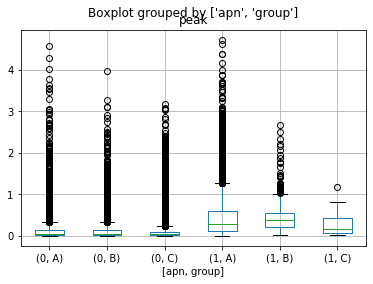

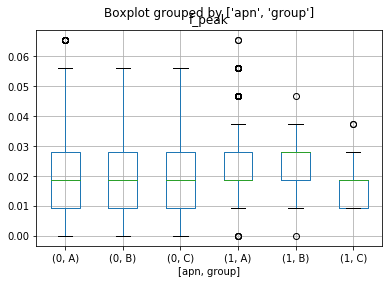

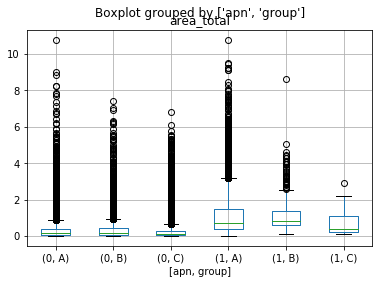

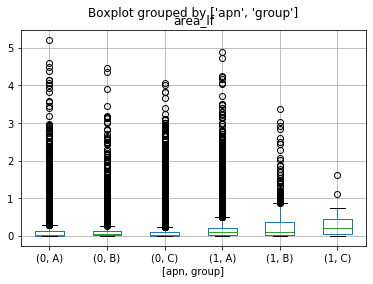

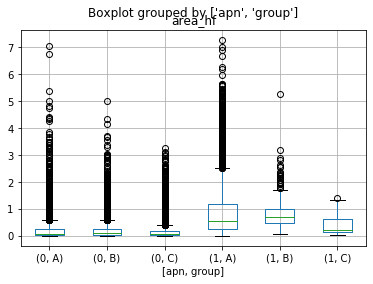

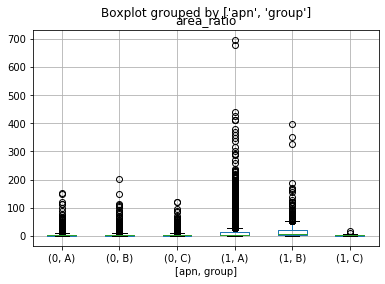

In [193]:
for feature in ['peak', 'f_peak', 'area_total', 'area_lf', 'area_hf', 'area_ratio']:
    df.boxplot(column=[feature], by=['apn', 'group'])

## 3.1 Simple model

In [81]:
train_df = pd.read_csv('resources\File_train.csv')
feature_col, label_col = ['peak', 'f_peak', 'area_total', 'area_lf', 'area_hf', 'area_ratio'], 'apn'
acc=[]
for seg_num in [1, 3, 5, 7]:
    df = features_psd(train_df['file'], seg_num=seg_num)
    mdl = LogisticRegression(solver='lbfgs')
    acc.append(model_evaluation_CV(mdl, df, train_df, n=5))

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning:

nperseg = 256 is greater than input length  = 139, using nperseg = 139

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning:

nperseg = 256 is greater than input length  = 144, using nperseg = 144

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning:

nperseg = 256 is greater than input length  = 142, using nperseg = 142

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning:

nperseg = 256 is greater than input length  = 143, using nperseg = 143

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning:

nperseg = 256 is greater than input length  = 140, using nperseg = 140

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning:

nperseg = 256 is great

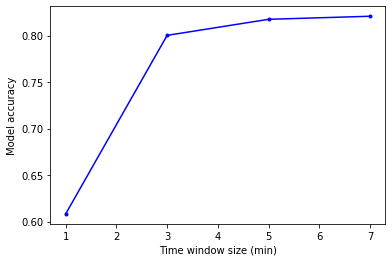

In [82]:
plt.plot([1, 3, 5, 7], acc, 'b.-')
plt.xlabel('Time window size (min)')
plt.ylabel('Model accuracy')
plt.show()

In [131]:
train_df = pd.read_csv('resources\File_train.csv')
feature_col, label_col = ['peak', 'f_peak', 'area_total', 'area_lf', 'area_hf', 'area_ratio'], 'apn'
acc=[]
for fs_new in [1.2, 2.4, 4.8, 9.6]:
    df = features_psd(train_df['file'], fs_new=fs_new, seg_num=5)
    mdl = LogisticRegression(solver='lbfgs')
    acc.append(model_evaluation_CV(mdl, df, train_df, n=5))

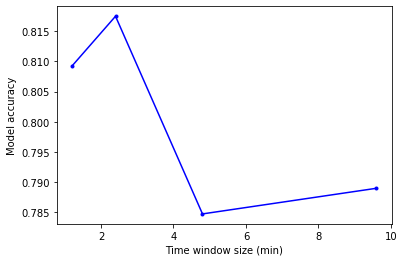

In [132]:
plt.plot([1.2, 2.4, 4.8, 9.6], acc, 'b.-')
plt.xlabel('Time window size (min)')
plt.ylabel('Model accuracy')
plt.show()

# 4. HRV

In [133]:
from hrvanalysis import get_time_domain_features, get_csi_cvi_features

In [158]:
def features_hrv(file_names, seg_num=1):
    # seg_num: Window size for feature extraction, should be odd number
    df= pd.DataFrame()
    
    file = 'a01'
    for file in file_names:
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute

        # Remove outliers 
        idx_valid = (hr < 2) & (hr > 0.5)
        hr = hr[idx_valid]
        t_hr = t_hr[idx_valid]

        # Extract range and sd for each 3-min window
        group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper() 
        for minute in range(len(apn) - seg_num + 1):
            try:
                idx = (t_hr > minute) & (t_hr < minute + seg_num)
                nn_intervals = (np.diff(t_hr[idx]) * 1000 * 60).astype(int) # Unit in ms
                features = get_time_domain_features(nn_intervals)
                nonlinear_features = get_csi_cvi_features(nn_intervals)

                features.update(nonlinear_features)
                features.update({
                    'apn': apn[minute + int(seg_num / 2)],
                    'file': file,
                    'group': group,
                })
                df = df.append(features, ignore_index=True)
            except:
                print(f'{file} has no data in minute {minute}')
        
    df['apn'] = df['apn'].astype(int)
    return df

In [159]:
train_df = pd.read_csv('resources\File_train.csv')
df = features_hrv(train_df['file'])
df

x20 has no data in minute 172
x20 has no data in minute 173
x20 has no data in minute 175
x20 has no data in minute 177
x20 has no data in minute 178
x20 has no data in minute 179
x20 has no data in minute 180
x20 has no data in minute 182
x20 has no data in minute 184


C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



,Modified_csi,apn,csi,cvi,cvnni,cvsd,file,group,max_hr,mean_hr,...,min_hr,nni_20,nni_50,pnni_20,pnni_50,range_nni,rmssd,sdnn,sdsd,std_hr
0,371.643844,0,1.303140,4.795280,0.061785,0.074545,x32,A,67.415730,58.558717,...,53.097345,47.0,34.0,83.928571,60.714286,240.0,76.671792,63.548397,76.668168,3.657039
1,1037.824779,0,2.255783,4.972356,0.087463,0.070334,x32,A,69.848661,59.435435,...,50.420168,44.0,24.0,77.192982,42.105263,331.0,71.541072,88.963433,71.461419,5.179581
2,300.029117,0,1.282149,4.630512,0.047408,0.057764,x32,A,62.500000,54.345651,...,50.420168,39.0,25.0,75.000000,48.076923,230.0,63.920754,52.460759,63.891272,2.655314
3,1120.944831,0,2.024967,5.179915,0.101153,0.088720,x32,A,69.848661,56.190981,...,46.911650,39.0,21.0,73.584906,39.622642,420.0,95.723661,109.138834,95.716473,5.830106
4,1639.415226,0,2.614783,5.177071,0.109412,0.077415,x32,A,75.093867,56.040307,...,46.875000,43.0,27.0,81.132075,50.943396,481.0,83.962102,118.664282,83.956814,6.693204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27094,4518.788395,0,8.880858,4.464679,0.113280,0.025437,c07,C,98.522167,76.170534,...,64.516129,18.0,1.0,24.657534,1.369863,321.0,20.325818,90.516556,20.115465,9.651823
27095,1423.847786,0,2.015980,5.393468,0.197601,0.174543,c07,C,107.334526,87.648907,...,38.734668,26.0,9.0,31.325301,10.843373,990.0,123.107627,139.370355,123.106660,14.018444
27096,933.834379,0,1.105475,5.809893,0.245725,0.327356,c07,C,95.389507,76.003291,...,28.585040,43.0,20.0,59.722222,27.777778,1470.0,268.254793,201.361488,268.254437,12.571403
27097,863.626971,0,0.806072,6.153530,0.341872,0.528223,c07,C,113.421550,72.760310,...,25.985275,37.0,23.0,56.060606,34.848485,1780.0,466.301256,301.795386,466.301155,15.163680


In [160]:
feature_col = df.drop(labels=['apn', 'file', 'group'], axis=1).columns

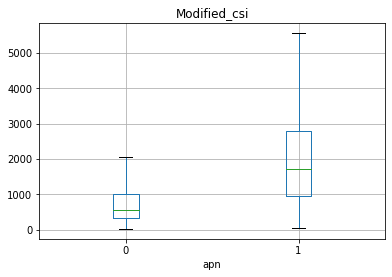

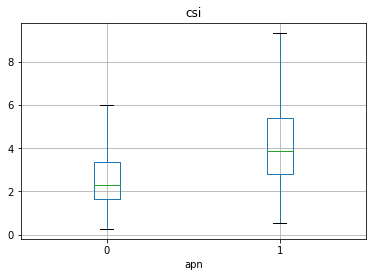

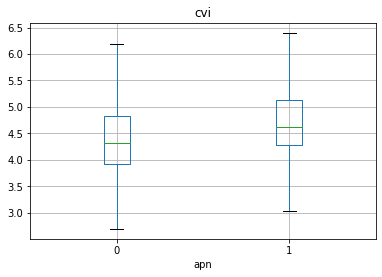

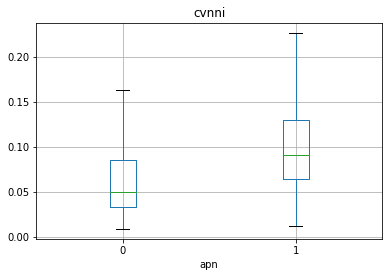

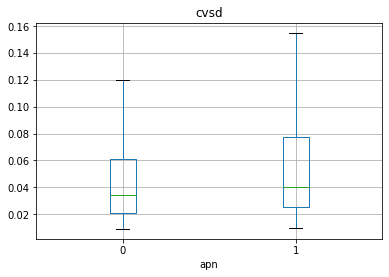

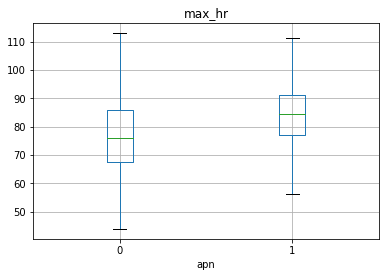

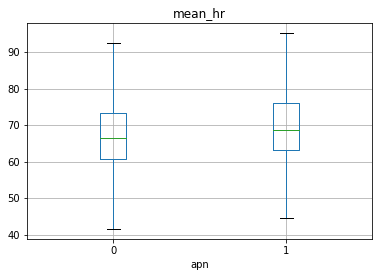

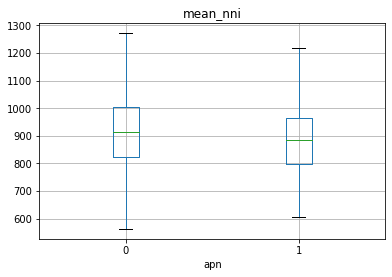

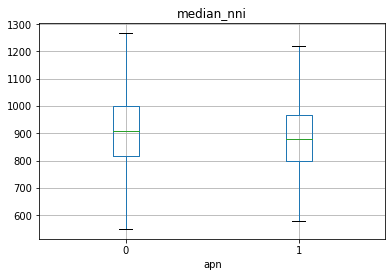

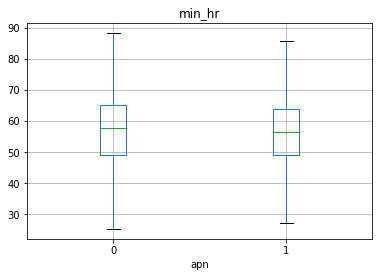

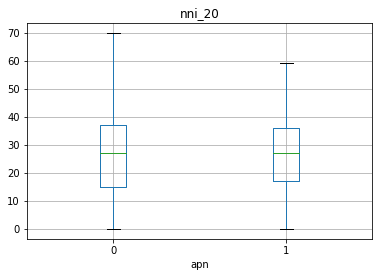

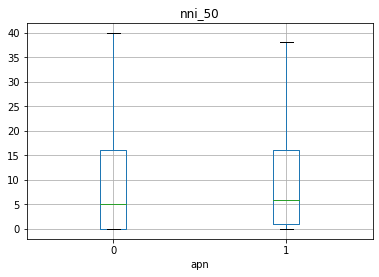

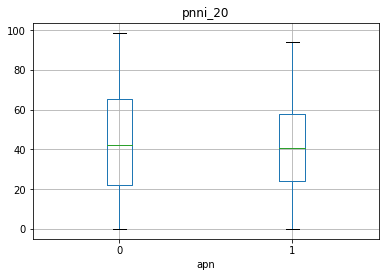

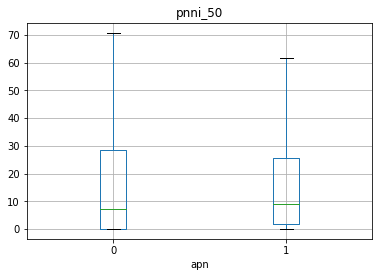

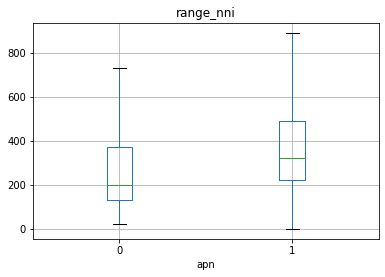

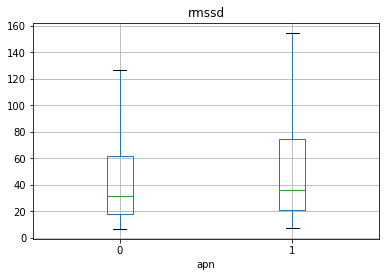

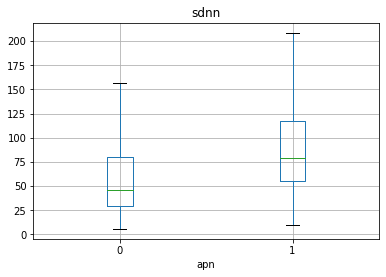

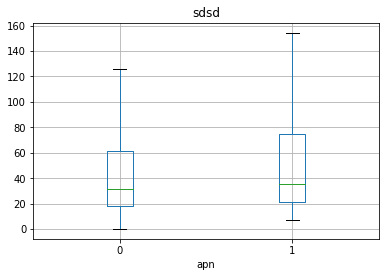

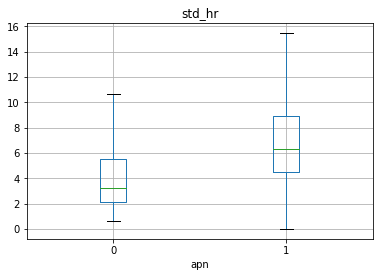

In [167]:
for feature in feature_col:
    ax = df.boxplot(column=feature, by='apn', showfliers=False)
    fig = ax.get_figure()
    fig.suptitle('')

## 4.1 Simple model

In [177]:
train_df = pd.read_csv('resources\File_train.csv')
label_col = 'apn'
acc=[]
for seg_num in [1, 3, 5, 7]:
    df = features_hrv(train_df['file'], seg_num=seg_num)
    df.dropna(inplace=True)
    mdl = LogisticRegression(solver='lbfgs', max_iter=1e4)
    acc.append(model_evaluation_CV(mdl, df, train_df, n=5))

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



x20 has no data in minute 172
x20 has no data in minute 173
x20 has no data in minute 175
x20 has no data in minute 177
x20 has no data in minute 178
x20 has no data in minute 179
x20 has no data in minute 180
x20 has no data in minute 182
x20 has no data in minute 184


C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\hrvanalysis\extract_features.py:106: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\hrvanalysis\extract_features.py:537: RuntimeWarning:

invalid value encountered in sqrt

x20 has no data in minute 177
x20 has no data in minute 178


C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\hrvanalysis\extract_features.py:106: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\hrvanalysis\extract_features.py:537: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\joey3\Anaconda3\envs\Apnea-ECG\lib\site-packages\hrvanalysis\extract_features.py:106: RuntimeWarning:

invalid value encountered in sqrt



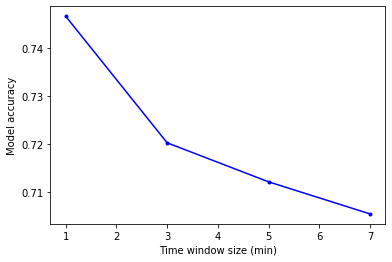

In [178]:
plt.plot([1, 3, 5, 7], acc, 'b.-')
plt.xlabel('Time window size (min)')
plt.ylabel('Model accuracy')
plt.show()

# 4. Combined features